In [649]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

In [650]:
def get_excel_data() -> DataFrame:
    file_name = "imaginedata.xlsx"
    sales_df1 = pd.read_excel(file_name, sheet_name="Year 2009-2010")
    sales_df2 = pd.read_excel(file_name, sheet_name="Year 2010-2011")

    combined_df = pd.concat([sales_df1, sales_df2])

    return combined_df

In [651]:
df = get_excel_data()
df = df.dropna()
df = df[~df["Description"].isin(["Manual", "POSTAGE", "Discount"])]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [688]:
def get_countries(df: DataFrame) -> DataFrame:
    countries = df[["Country"]].drop_duplicates()
    countries = countries.reset_index(drop=True)
    countries["country_id"] = countries.index
    countries = countries.rename(columns={"Country": "country"})
    return countries


def get_stock_codes(df: DataFrame) -> DataFrame:
    stock_codes = df[["StockCode", "Description", "Price"]].drop_duplicates()
    stock_codes = stock_codes.reset_index(drop=True)
    stock_codes["stockcode_id"] = stock_codes.index
    stock_codes = stock_codes.rename(
        columns={
            "StockCode": "stockcode",
            "Description": "description",
            "Price": "price",
        }
    )
    return stock_codes


def get_customers(countries: DataFrame, df: DataFrame) -> DataFrame:
    cus = df[["Customer ID", "Country"]].drop_duplicates()
    cus = pd.merge(cus, countries, left_on="Country", right_on="country", how="left")
    cus = cus[["Customer ID", "country_id"]]
    cus = cus.rename(columns={"Customer ID": "customer", "country": "country_id"})
    cus = cus.reset_index(drop=True)
    cus["customerid"] = cus.index

    return cus


def get_invoices(customers_df: DataFrame, df: DataFrame) -> DataFrame:
    invoices = df[["Invoice", "InvoiceDate", "Customer ID"]].drop_duplicates()
    invoices = pd.merge(
        invoices, customers_df, left_on="Customer ID", right_on="customer", how="left"
    )
    invoices = invoices[["Invoice", "InvoiceDate", "customerid"]]
    invoices = invoices.reset_index(drop=True)
    invoices["invoiceid"] = invoices.index
    invoices = invoices.rename(
        columns={"Invoice": "invoice", "InvoiceDate": "invoicedate"}
    )
    # total items per invoice
    grouped_invoices = df.groupby("Invoice").agg({"Quantity": "sum"})
    invoices = pd.merge(
        invoices, grouped_invoices, left_on="invoice", right_on="Invoice", how="left"
    )
    invoices = invoices.rename(columns={"Quantity": "totalitems"})

    return invoices


def get_invoices_items(
    invoices: DataFrame, stock_codes: DataFrame, df: DataFrame
) -> DataFrame:
    invoices_items = df[["Invoice", "StockCode", "Quantity", "Price"]].drop_duplicates()
    invoices_items = pd.merge(
        invoices_items, invoices, left_on="Invoice", right_on="invoice", how="left"
    )
    invoices_items = pd.merge(
        invoices_items,
        stock_codes,
        left_on="StockCode",
        right_on="stockcode",
        how="left",
    )
    invoices_items = invoices_items[["invoiceid", "stockcode_id", "Quantity", "Price"]]
    invoices_items = invoices_items.reset_index(drop=True)
    invoices_items["invoiceitemid"] = invoices_items.index
    invoices_items = invoices_items.rename(
        columns={"Quantity": "quantity", "Price": "unitprice"}
    )

    return invoices_items

In [689]:
countries_df = get_countries(df)
stock_codes_df = get_stock_codes(df)
customers_df = get_customers(countries_df, df)
invoices_df = get_invoices(customers_df, df)
invoice_items_df= get_invoices_items(invoices_df, stock_codes_df, df)

In [654]:
def get_top_most_items_per_country(countries, customers, invoices) -> DataFrame:
    customers_invoices = pd.merge(
        invoices, customers, left_on="customerid", right_on="customerid", how="left"
    )
    customers_invoices = customers_invoices[
        ["customerid", "invoiceid", "totalitems", "country_id"]
    ]

    customers_items = customers_invoices.groupby("customerid").agg(
        {"totalitems": "sum"}
    )

    customers = customers.copy()

    customers["totalitems"] = customers_items["totalitems"]

    items_per_country = pd.merge(
        customers, countries, left_on="country_id", right_on="country_id", how="left"
    )

    items_per_country = items_per_country[["country", "totalitems"]]
    items_per_country = items_per_country.groupby("country").agg({"totalitems": "sum"})
    items_per_country = items_per_country.sort_values(by="totalitems", ascending=False)

    items_per_country_2 = items_per_country.copy()
    items_per_country_2 = items_per_country_2.iloc[1:]

    return items_per_country[:5], items_per_country_2[:5]


items_per_country, items_per_country_2 = get_top_most_items_per_country(
    countries_df, customers_df, invoices_df
)

In [655]:
def get_top_revenue_items(stock_codes, invoices_items) -> DataFrame:
    revenue_items = pd.merge(
        invoices_items,
        stock_codes,
        left_on="stockcode_id",
        right_on="stockcode_id",
        how="left",
    )

    revenue_items["stockcode"] = (
        revenue_items["stockcode"].astype(str)
        + "("
        + revenue_items["price"].astype(str)
        + ")"
    )
    revenue_items["description"] = (
        revenue_items["description"] + " (" + revenue_items["price"].astype(str) + ")"
    )

    sales = revenue_items.groupby(
        ["stockcode_id", "stockcode", "description", "price"]
    ).agg({"quantity": "sum"})
    sales["totalprice"] = sales["quantity"] * sales.index.get_level_values("price")
    sales = sales.sort_values(by="totalprice", ascending=False)
    return sales[:10]


revenew_items = get_top_revenue_items(stock_codes_df, invoice_items_df)

,,,,quantity,totalprice
stockcode_id,stockcode,description,price,,
9855,17003(57.6),BROCADE RING PURSE (57.6),57.60,69343,3994156.80
9715,22502(649.5),PICNIC BASKET WICKER 60 PIECES (649.5),649.50,2965,1925767.50
10789,22423(24.96),REGENCY CAKESTAND 3 TIER (24.96),24.96,22760,568089.60
11371,85123A(5.79),WHITE HANGING HEART T-LIGHT HOLDER (5.79),5.79,88585,512907.15
11244,85099B(4.13),JUMBO BAG RED RETROSPOT (4.13),4.13,92470,381901.10
5324,22423(12.75),REGENCY CAKESTAND 3 TIER (12.75),12.75,22760,290190.00
8022,85123A(3.24),WHITE HANGING HEART T-LIGHT HOLDER (3.24),3.24,88585,287015.40
10660,85123A(3.2),WHITE HANGING HEART T-LIGHT HOLDER (3.2),3.20,88585,283472.00
12785,85123A(2.95),CREAM HANGING HEART T-LIGHT HOLDER (2.95),2.95,88585,261325.75


In [657]:
def get_top_sales_by_month(invoices):
    invoices["year"] = invoices["invoicedate"].dt.year
    invoices["month"] = invoices["invoicedate"].dt.month
    sales_by_month = invoices.groupby(["year", "month"]).agg({"totalitems": "sum"})
    return sales_by_month


top_sales_by_month = get_top_sales_by_month(invoices_df)

In [658]:
top_sales_by_month
# items_per_country
# items_per_country_2
revenew_items

,,,,quantity,totalprice
stockcode_id,stockcode,description,price,,
9855,17003(57.6),BROCADE RING PURSE (57.6),57.60,69343,3994156.80
9715,22502(649.5),PICNIC BASKET WICKER 60 PIECES (649.5),649.50,2965,1925767.50
10789,22423(24.96),REGENCY CAKESTAND 3 TIER (24.96),24.96,22760,568089.60
11371,85123A(5.79),WHITE HANGING HEART T-LIGHT HOLDER (5.79),5.79,88585,512907.15
11244,85099B(4.13),JUMBO BAG RED RETROSPOT (4.13),4.13,92470,381901.10
5324,22423(12.75),REGENCY CAKESTAND 3 TIER (12.75),12.75,22760,290190.00
8022,85123A(3.24),WHITE HANGING HEART T-LIGHT HOLDER (3.24),3.24,88585,287015.40
10660,85123A(3.2),WHITE HANGING HEART T-LIGHT HOLDER (3.2),3.20,88585,283472.00
12785,85123A(2.95),CREAM HANGING HEART T-LIGHT HOLDER (2.95),2.95,88585,261325.75


/Users/tarkark/mambaforge/envs/imagine/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


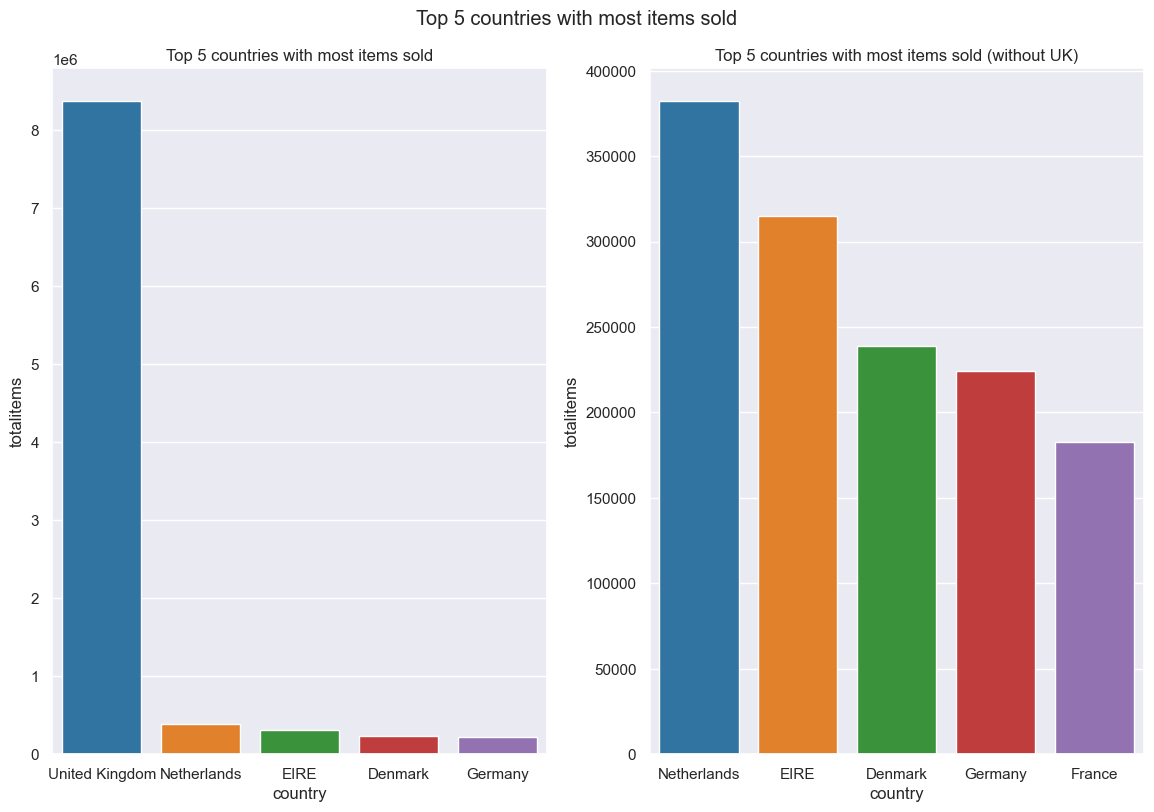

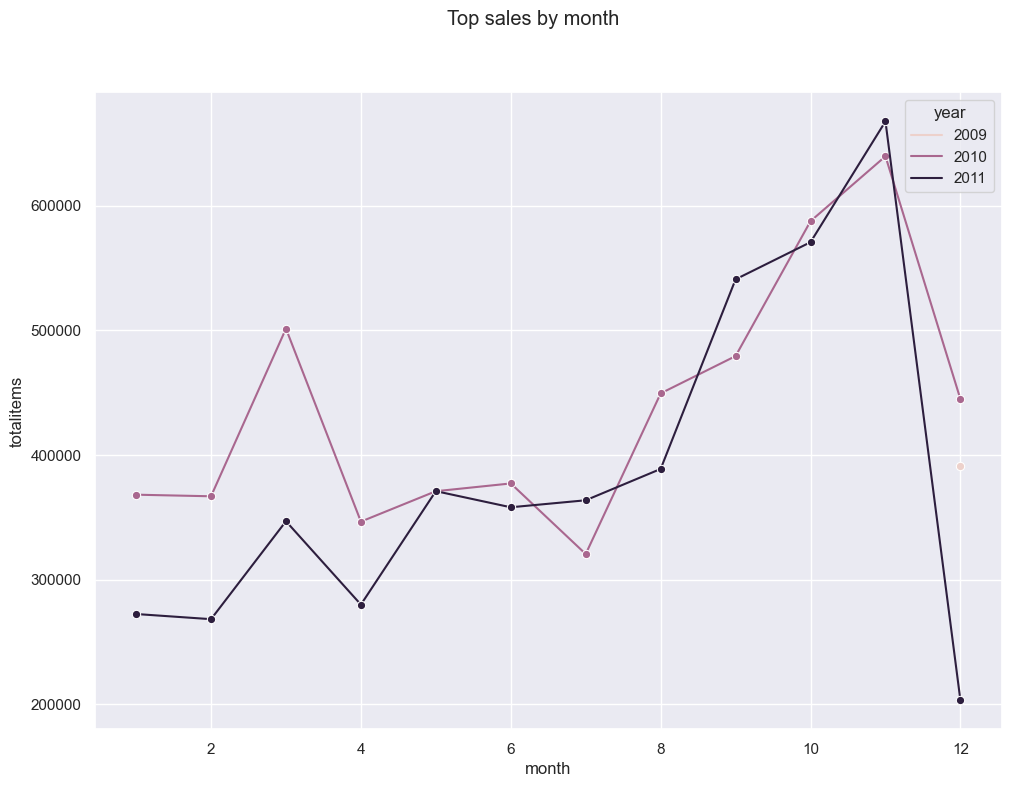

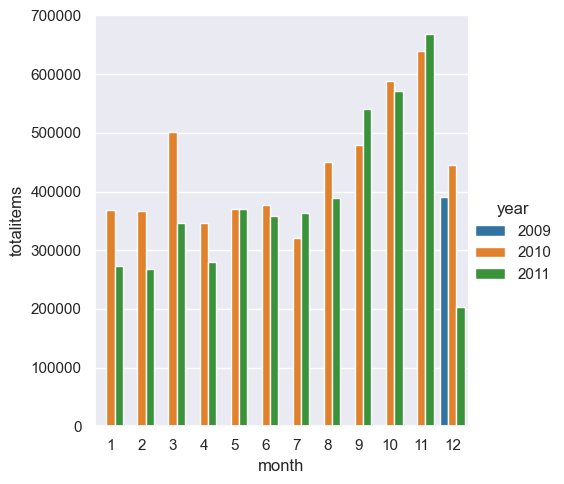

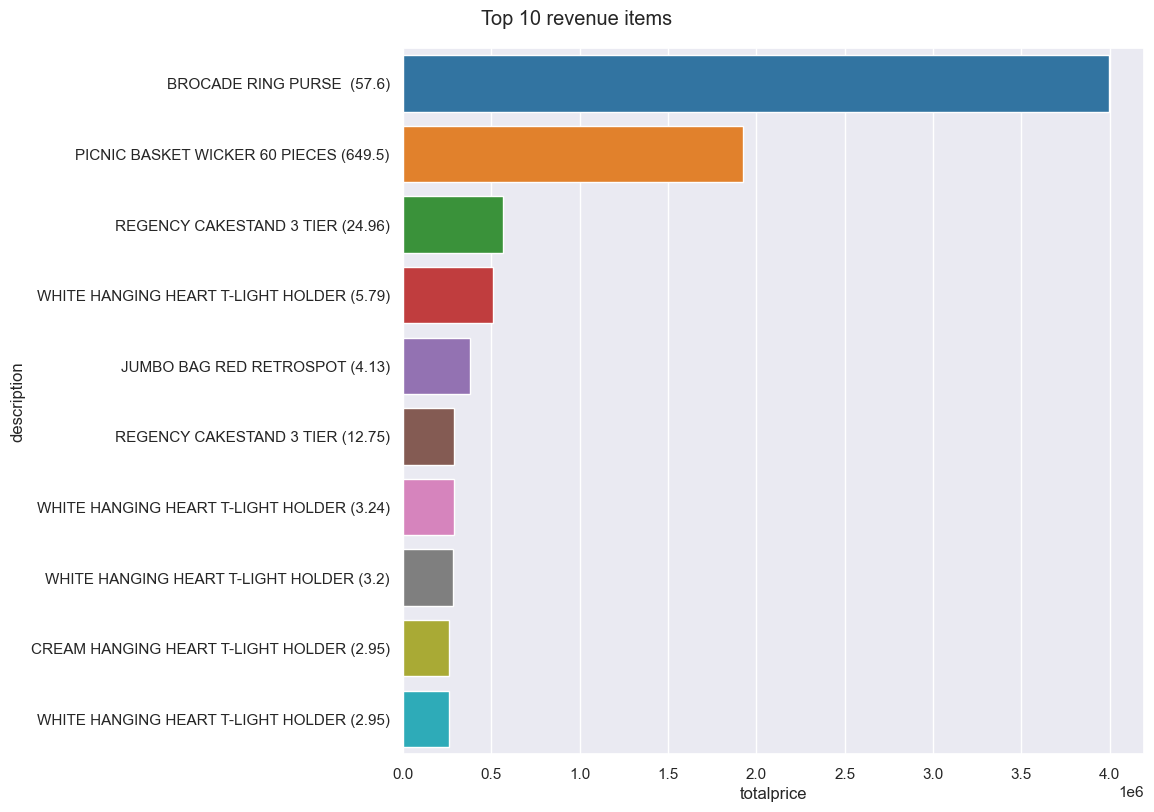

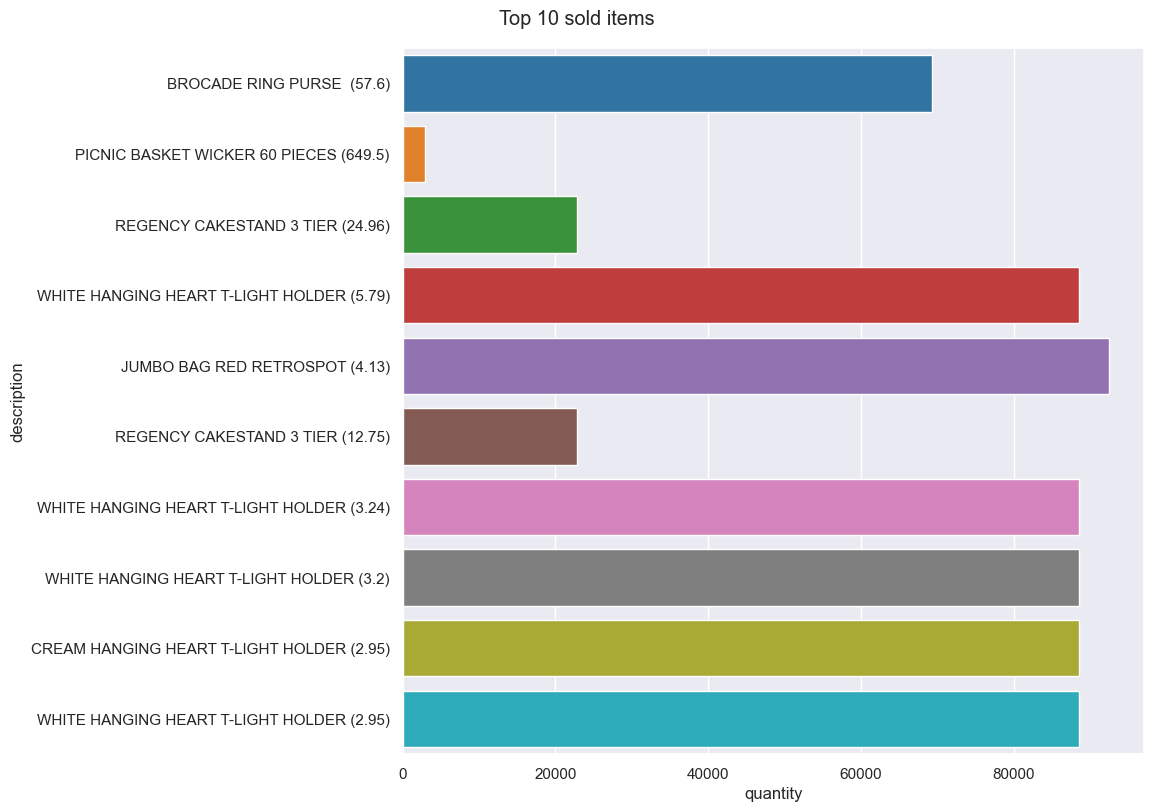

In [695]:
sns.set(style="darkgrid", palette="tab10", color_codes=True)


fig, ax = plt.subplots(1, 2,layout='tight')
fig.suptitle("Top 5 countries with most items sold")
ax[0].set_title("Top 5 countries with most items sold")
ax[1].set_title("Top 5 countries with most items sold (without UK)")

sns.barplot(x=items_per_country.index, y=items_per_country["totalitems"], ax=ax[0])
sns.barplot(x=items_per_country_2.index, y=items_per_country_2["totalitems"], ax=ax[1])


fig2, ax2 = plt.subplots()
fig2.suptitle("Top sales by month")

sns.lineplot(
    x=top_sales_by_month.index.get_level_values("month"),
    y=top_sales_by_month["totalitems"],
    hue=top_sales_by_month.index.get_level_values("year"),
    ax=ax2,
    marker="o",
)

sns.catplot(
    x="month",
    y="totalitems",
    hue="year",
    data=top_sales_by_month.reset_index(),
    kind="bar",
)


fig3, ax3 = plt.subplots(layout='tight')
fig3.suptitle("Top 10 revenue items")


sns.barplot(
    data=revenew_items.reset_index(),
    x="totalprice",
    y="description",
    ax=ax3,
)

fig4, ax4 = plt.subplots(layout='tight')
fig4.suptitle("Top 10 sold items")

sns.barplot(
    data=revenew_items.reset_index(),
    x="quantity",
    y="description",
    ax=ax4,
)

plt.show()